# Using LoRA for Efficient Stable Diffusion Fine-Tuning 
source: https://huggingface.co/blog/lora

In [1]:
import torch
from torch.nn import functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import os, shutil
import random

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


from diffusers import DiffusionPipeline,StableDiffusionPipeline,AutoencoderKL,UNet2DConditionModel
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
from diffusers import DDPMScheduler,  DPMSolverMultistepScheduler, DDIMScheduler

from diffusers.utils import convert_state_dict_to_diffusers

from peft import LoraConfig, set_peft_model_state_dict
from peft.utils import get_peft_model_state_dict

In [2]:
transform = transforms.Compose([ transforms.Resize((512,512)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5],[0.5]),
                            transforms.RandomHorizontalFlip(),
])

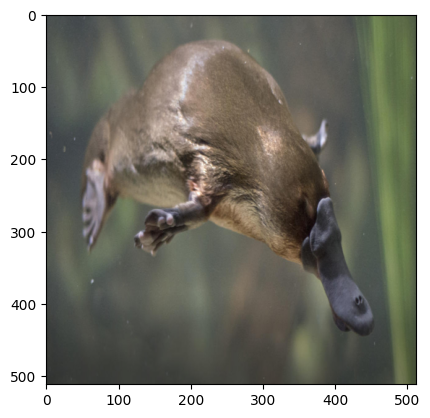

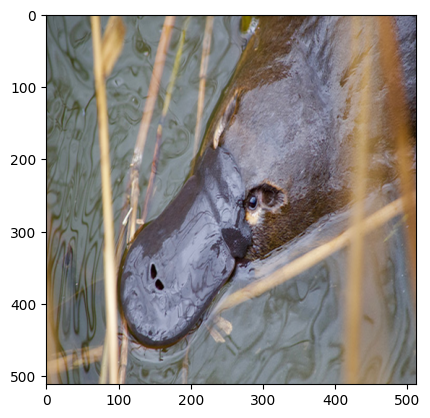

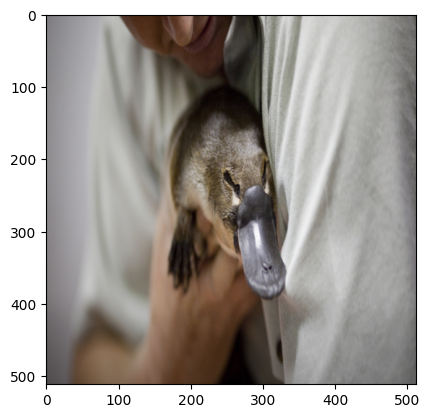

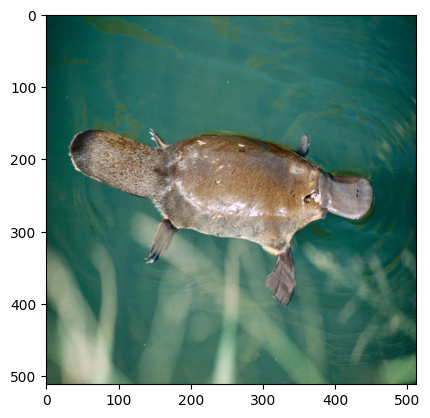

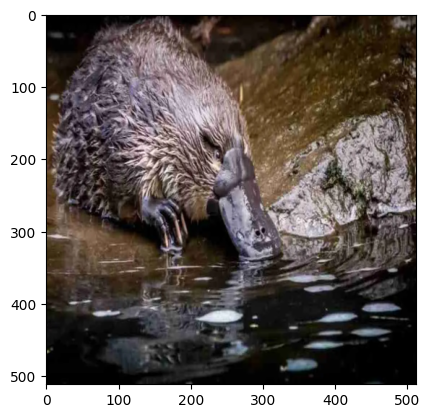

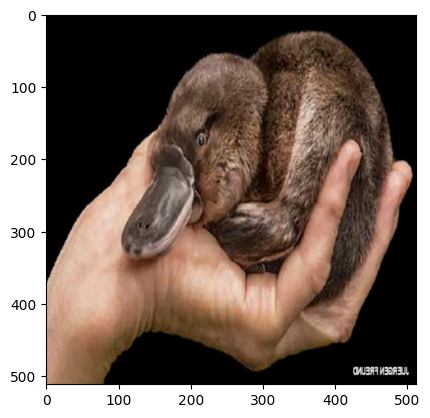

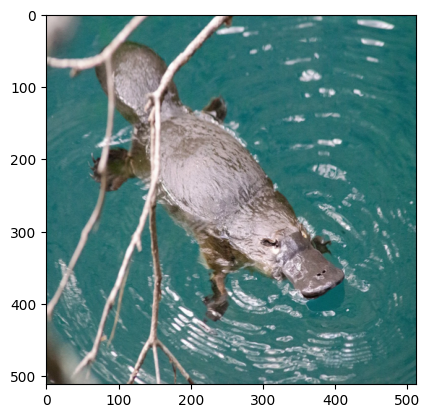

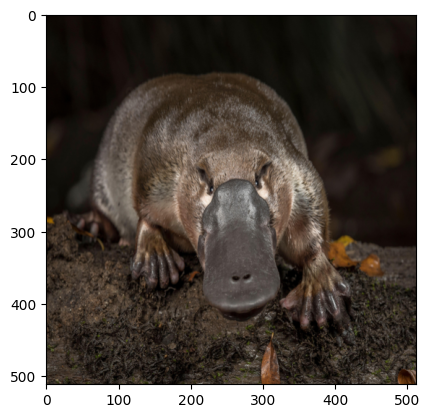

In [3]:
for img_path in Path('platypus').iterdir():
    img = Image.open(img_path)
    img = transform(img)
    plt.imshow(img.permute(1,2,0)*0.5+0.5)
    plt.show()

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load all the components

In [6]:
model_id = 'stable-diffusion-v1-5/stable-diffusion-v1-5'
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")

noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")
# Move to GPU
vae.to(device)
unet.to(device)
text_encoder.to(device)
# We only train the additional adapter LoRA layers
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

print('loaded sucessfully')

loaded sucessfully


## Dataset and dataloader

In [7]:
image_paths = list(Path('platypus').iterdir())

class DiffusionDataset(Dataset):
    def __init__(self,image_paths,transform):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image = self.transform(image)
        return {'image':image,'caption':'platypus'}

In [8]:
train_dataset = DiffusionDataset(image_paths,transform)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [9]:
for batch in train_dataloader:
    print(batch['image'].shape)
    print(batch['caption'])
    break

torch.Size([2, 3, 512, 512])
['platypus', 'platypus']


In [10]:
with torch.inference_mode():
    image_tensor = batch['image'].to(device)
    model_input = vae.encode(image_tensor).latent_dist.sample()
    model_input = model_input * vae.config.scaling_factor
print(model_input.shape)

torch.Size([2, 4, 64, 64])


In [11]:
text_inputs = tokenizer(batch['caption'], padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors='pt')

with torch.inference_mode():
    text_embeddings = text_encoder(text_inputs.input_ids.to(device))[0]
    
print(text_embeddings.shape)

torch.Size([2, 77, 768])


## Unet Training Preparation

In [12]:
unet.enable_xformers_memory_efficient_attention()
unet.enable_gradient_checkpointing()

In [13]:
# LoRA Config
unet_lora_config = LoraConfig(
    r=32,
    lora_alpha=32,
    init_lora_weights="gaussian",
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
)

unet.add_adapter(unet_lora_config)

In [14]:
for name,param in unet.named_parameters():
    print(name, param.requires_grad)

conv_in.weight False
conv_in.bias False
time_embedding.linear_1.weight False
time_embedding.linear_1.bias False
time_embedding.linear_2.weight False
time_embedding.linear_2.bias False
down_blocks.0.attentions.0.norm.weight False
down_blocks.0.attentions.0.norm.bias False
down_blocks.0.attentions.0.proj_in.weight False
down_blocks.0.attentions.0.proj_in.bias False
down_blocks.0.attentions.0.transformer_blocks.0.norm1.weight False
down_blocks.0.attentions.0.transformer_blocks.0.norm1.bias False
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.base_layer.weight False
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_A.default.weight True
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_B.default.weight True
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.base_layer.weight False
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_A.default.weight True
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_B.default.weig

In [15]:
# Optimizer
optimizer_class = torch.optim.AdamW
params_to_optimize = list(filter(lambda p: p.requires_grad, unet.parameters())) 
optimizer = optimizer_class(
        params_to_optimize,
        lr=1e-4,#1e-4
        betas=(0.9, 0.999),
        weight_decay=1e-2,
        eps=1e-08,
    )
# add Unet to training mode
unet.train()

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): lora.Linear(
                  (base_layer): Linear(in_features=320, out_features=320, bias=False)
                  (lora_dropout): ModuleDict(
                    (default): Identity()

# Start the training loop

In [18]:
def generate_and_save(unet, 
                      step, 
                      vae, 
                      text_encoder, 
                      tokenizer, 
                      noise_scheduler, 
                      seed=10, 
                      guidance_scale=7.5,
                      num_inference_steps=20):

    # put UNet in eval mode
    unet.eval()

    # setup pipeline
    pipeline = StableDiffusionPipeline(
        vae=vae,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        unet=unet,
        scheduler=noise_scheduler,
        safety_checker=None,
        feature_extractor=None,
    )

    # replace scheduler with DPMSolverMultistep
    # pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
    #     pipeline.scheduler.config, algorithm_type="sde-dpmsolver++"
    # )
    pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

    # prompts
    prompts = ['platypus']

    # generate
    images = pipeline(
        prompt=prompts*4,
        cross_attention_kwargs={"scale": 1.0},
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        generator=torch.manual_seed(seed),
    )

    # plot
    plt.figure(figsize=(8,8))
    plt.subplot(2,2,1)
    plt.imshow(images.images[0])
    plt.axis("off")

    plt.subplot(2,2,2)
    plt.imshow(images.images[1])
    plt.axis("off")

    plt.subplot(2,2,3)
    plt.imshow(images.images[2])
    plt.axis("off")
    
    plt.subplot(2,2,4)
    plt.imshow(images.images[3])
    plt.axis("off")

    plt.tight_layout()

    # ensure directory exists
    save_dir = f"runs/generated_images"
    os.makedirs(save_dir, exist_ok=True)

    # save PNG
    out_path = os.path.join(save_dir, f"step_{step}.png")
    plt.savefig(out_path, dpi=300)
    plt.close()
    
    torch.cuda.empty_cache()

    return out_path

In [ ]:
max_train_steps=5000
eval_steps=1000
accumulation_steps=4

progress_bar = tqdm(
    range(0, max_train_steps),
    desc="Steps"
)

running_loss=[]

train_step=0
while train_step < max_train_steps:
    for batch in train_dataloader:
        image_tensor =batch['image'].to(device)#.to(torch.float16)
        tokenized_text = tokenizer(batch['caption'], padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors='pt').to(device)
        
        # encode the tokenized text
        with torch.no_grad():
            encoder_hidden_states = text_encoder(**tokenized_text)[0]
            model_input = vae.encode(image_tensor).latent_dist.sample()
            model_input = model_input * vae.config.scaling_factor
        
        # Sample noise that we'll add to the latents
        noise = torch.randn_like(model_input)
        bsz = model_input.shape[0]
        
        # Sample a random timestep for each image
        timesteps = noise_scheduler.timesteps[torch.randperm(len(noise_scheduler.timesteps))[:bsz]].to(device)
        timesteps = timesteps.long()
        # Add noise to the model input according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_model_input = noise_scheduler.add_noise(model_input, noise, timesteps)

        # Predict the noise residual
       
        model_pred = unet(noisy_model_input,timesteps, encoder_hidden_states, return_dict=False)[0]

        loss = F.mse_loss(model_pred, noise)/accumulation_steps
        running_loss.append(loss.item())
        loss.backward()
    
        if (train_step+1)%accumulation_steps==0:
            optimizer.step()
            optimizer.zero_grad()
            
        # Update progress bar with loss value
        progress_bar.set_postfix(loss=loss.item())  # Assuming loss is a tensor; use .item() to get the float value

        # Update the progress bar by one step
        progress_bar.update(1)
        
        train_step=train_step+1
        
        if train_step % eval_steps == 0:
            unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet))
            
            os.makedirs(f'runs/ckpt_{train_step}',exist_ok=True)
            output_dir=f'runs/ckpt_{train_step}'
            StableDiffusionPipeline.save_lora_weights(save_directory=output_dir,
                                                        unet_lora_layers=unet_lora_state_dict)
            
            generate_and_save(unet=unet, 
                  step=train_step , 
                  vae=vae, 
                  text_encoder=text_encoder, 
                  tokenizer=tokenizer, 
                  noise_scheduler=noise_scheduler,
                  seed=10, 
                  guidance_scale=7.5,
                  num_inference_steps=50)

        if train_step > max_train_steps:
            break

    if train_step > max_train_steps:
        break
    
plt.plot(running_loss)
plt.show()
torch.cuda.empty_cache()

# Inference Using Lora

In [1]:
from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch
from pathlib import Path
from diffusers.utils import load_image
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
model_id = 'stable-diffusion-v1-5/stable-diffusion-v1-5'
pipeline = StableDiffusionPipeline.from_pretrained(model_id,
                                                    safety_checker=None, 
                                                    torch_dtype=torch.float16).to(device)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

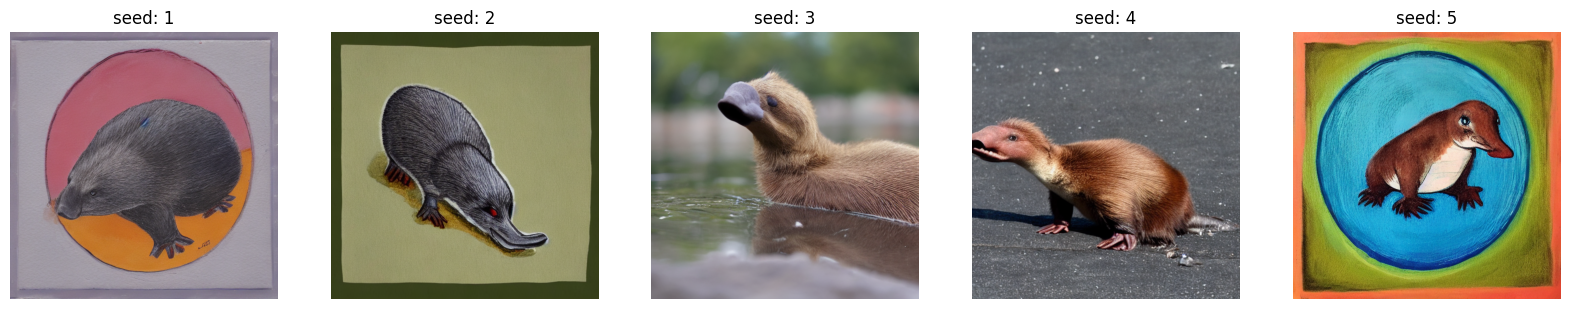

In [3]:
gen_images=[]
seeds = [1,2,3,4,5]
for seed in seeds:
    gen_image = pipeline(
                        prompt="platypus",
                        guidance_scale=8,
                        num_inference_steps=25,
                        height=512,
                        width=512,
                        cross_attention_kwargs={"scale": 0.0},
                        clip_skip=2,
                        generator=torch.manual_seed(seed)
                    ).images[0]

    gen_images.append(gen_image)
    

fig,axes = plt.subplots(1,5,figsize=(20,10))
for i,ax in enumerate(axes):
    ax.imshow(gen_images[i])
    ax.set_title(f"seed: {seeds[i]}")
    ax.axis('off')
plt.show()

# Load LoRA weights

In [4]:
pipeline.load_lora_weights(
    "runs/ckpt_2000",
)

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/25 [00:00<?, ?it/s]

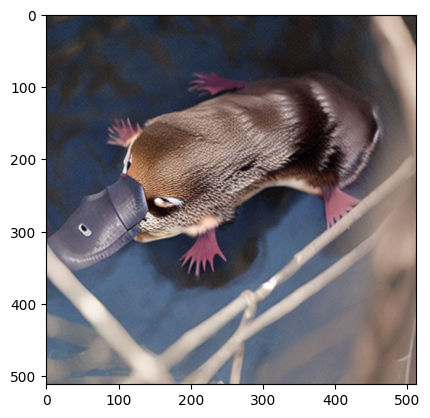

In [5]:
gen_image = pipeline(
    prompt="platypus",
    guidance_scale=8,
    num_inference_steps=25,
    height=512,
    width=512,
    cross_attention_kwargs={"scale": 1.0},
    clip_skip=2,
    generator=torch.manual_seed(0)
).images[0]

plt.imshow(gen_image)
plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

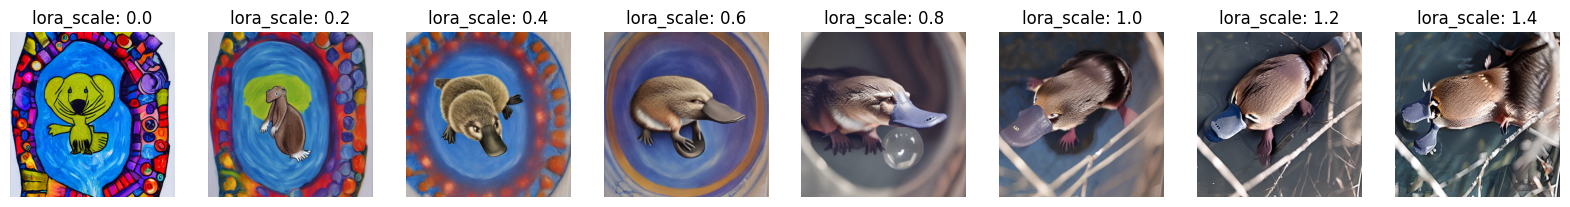

In [6]:
gen_images=[]
lora_scales = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4]
for lora_scale in lora_scales:
    gen_image = pipeline(
                        prompt="platypus",
                        guidance_scale=7.5,
                        num_inference_steps=25,
                        height=512,
                        width=512,
                        cross_attention_kwargs={"scale": lora_scale},
                        clip_skip=2,
                        generator=torch.manual_seed(0)
                    ).images[0]

    gen_images.append(gen_image)
    

fig,axes = plt.subplots(1,8,figsize=(20,10))
for i,ax in enumerate(axes):
    ax.imshow(gen_images[i])
    ax.set_title(f"lora_scale: {lora_scales[i]}")
    ax.axis('off')
plt.show()

# Effect of Training steps

In [7]:
pipeline.get_list_adapters()

{'unet': ['default_0']}

In [8]:
pipeline.delete_adapters("default_0")

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/30 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/30 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/30 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/30 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/30 [00:00<?, ?it/s]

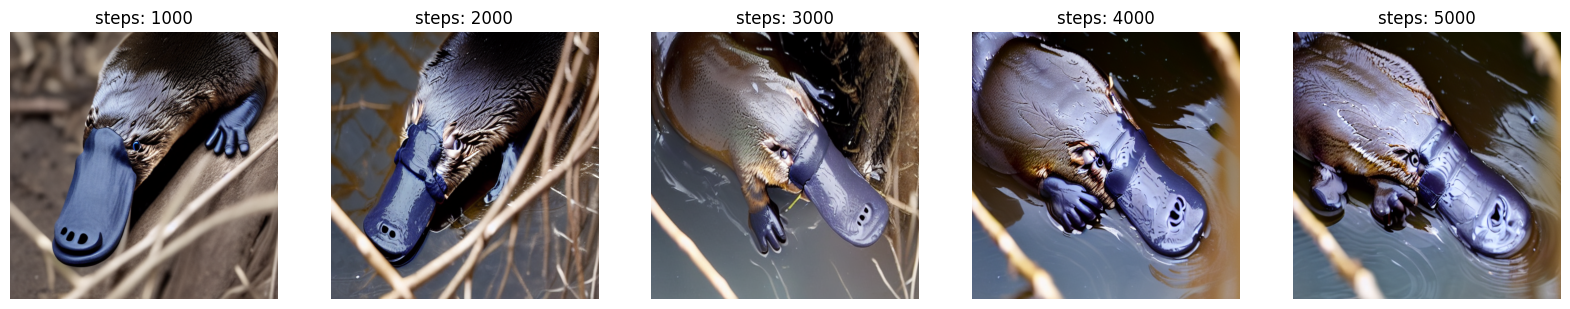

In [10]:
gen_images=[]
training_step_list = [1000,2000,3000,4000,5000]
for training_steps in training_step_list:
    
    pipeline.load_lora_weights(f"runs/ckpt_{training_steps}",adapter_name='platypus')
    
    gen_image = pipeline(
                        prompt="platypus",
                        guidance_scale=7.5,
                        num_inference_steps=30,
                        height=512,
                        width=512,
                        cross_attention_kwargs={"scale": 0.8},
                        generator=torch.manual_seed(0)
                    ).images[0]

    gen_images.append(gen_image)
    
    pipeline.delete_adapters("platypus")
    

fig,axes = plt.subplots(1,5,figsize=(20,10))
for i,ax in enumerate(axes):
    ax.imshow(gen_images[i])
    ax.set_title(f"steps: {training_step_list[i]}")
    ax.axis('off')
plt.show()

## Combine with different styles

In [11]:
pipeline.load_lora_weights(f"runs/ckpt_2000",adapter_name='platypus')

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

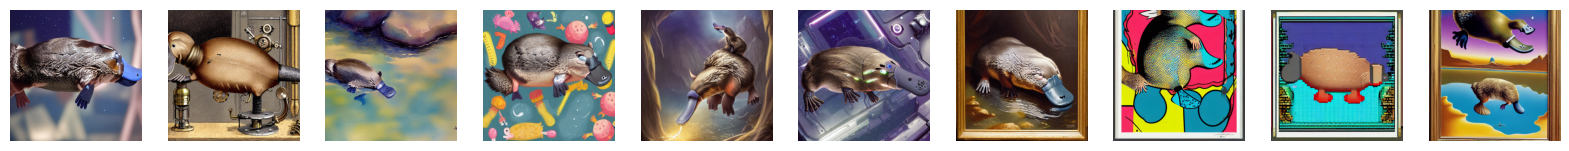

In [14]:
platypus_prompts = [
    "A cyberpunk platypus",
    "A steampunk platypus with brass gears and mechanical limbs, intricate Victorian-style machinery, warm tones, highly detailed illustration",
    "A platypus swimming in a serene river, soft watercolor painting, pastel colors, gentle brush strokes, dreamy atmosphere",
    "Cute cartoon platypus, big expressive eyes, playful pose, bright cheerful colors, whimsical style, 2D animation style",
    "A fantasy platypus wearing mystical armor, magical glowing runes on its body, standing on a cliff, dramatic lighting, epic fantasy illustration",
    "A cybernetic platypus, robotic enhancements, glowing circuits, sci-fi aesthetic, sleek metallic textures, high detail, digital art",
    "A platypus in the wild, painted in classical oil painting style, rich textures, dramatic lighting, realistic yet painterly, Baroque-inspired composition",
    "A pop art platypus, vibrant contrasting colors, bold outlines, comic-style halftone patterns, playful modern art",
    "A platypus rendered in retro pixel art, 16-bit video game style, colorful small-scale grid, cute and nostalgic",
    "A surreal platypus floating in a dreamlike landscape, abstract shapes, vibrant colors, imaginative surrealism, Salvador Dali inspired"
]

gen_images=[]

for prompt in platypus_prompts:
    gen_image = pipeline(
                        prompt=prompt,
                        guidance_scale=7.5,
                        num_inference_steps=25,
                        height=512,
                        width=512,
                        cross_attention_kwargs={"scale": 0.9},
                        generator=torch.manual_seed(42)
                    ).images[0]

    gen_images.append(gen_image)
    

fig,axes = plt.subplots(1,10,figsize=(20,5))
for i,ax in enumerate(axes):
    ax.imshow(gen_images[i])
    ax.axis('off')
plt.show()
